## BAO fit for cubix box

In [66]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
# %matplotlib inline

from cosmoprimo.fiducial import DESI, AbacusSummit
from mockfactory import utils, DistanceToRedshift, Catalog
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerCorrelationFunctionMultipoles
from desilike.observables.galaxy_clustering import TracerCorrelationFunctionMultipolesObservable, BAOCompressionObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike.samples.profiles import Profiles
from desilike.samplers.emcee import EmceeSampler
from desilike.samples import plotting, Chain
from desilike import setup_logging

sys.path.append('../../')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX
from fit_cubic_tools import set_bao_likelihood
%load_ext autoreload
%autoreload 2

setup_logging()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def load_cubic_data_fns(tracer, z_eff, grid_cosmo, recon):
    base_dir = f'/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/{tracer}/cosmo_2/z{z_eff:.3f}/'
    if recon == True:
        files=glob.glob(base_dir+f'/AbacusSummit_base_c002_ph*/allcounts_rec_c{grid_cosmo}_{tracer}_z{z_eff:.3f}_SHOD_kibo-v1_v0.1_PIP.npy')
    elif recon == False:
        files=glob.glob(base_dir+f'/AbacusSummit_base_c002_ph*/allcounts_c{grid_cosmo}_{tracer}_z{z_eff:.3f}_SHOD_kibo-v1_v0.1_PIP.npy')
    return files

def load_cubic_covariance(tracer, z_eff, recon, ells):
    if recon == True:
        cov_dir = '/global/homes/s/shengyu/project_rc/main/Y3/data/covariance/recon_sm15_IFFT_recsym'
    elif recon == False:
        cov_dir = '/global/homes/s/shengyu/project_rc/main/Y3/data/covariance'
    cov_fn =  cov_dir + f'/xi024_{tracer}_GCcomb_z0.4-0.6_default_FKP_lin4_s20-200_cov_RascalC.txt'
    cov_matrix = np.loadtxt(cov_fn)
    mono_indices = np.arange(10, 33)  # s: [60, 150] in BAO fitting
    quad_indices = np.arange(55, 78)
    selected_indices = np.concatenate([mono_indices, quad_indices])
    cov_cut = cov_matrix[np.ix_(selected_indices, selected_indices)]
    return cov_cut

def set_bao_likelihood(data_args):
    ells = (0,2)
    broadband = None
    (tracer , z_eff, grid_cosmo, recon) = data_args 
    data_fns = load_cubic_data_fns(tracer , z_eff, grid_cosmo, recon)
    cov = load_cubic_covariance(tracer , z_eff, recon,  ells)
    if grid_cosmo == '000':
        cosmo = DESI()
    elif grid_cosmo == '002':
        cosmo = AbacusSummit(2)
    template = BAOPowerSpectrumTemplate(z=z_eff, cosmo = cosmo, apmode = 'qisoqap',)
    theory = DampedBAOWigglesTracerCorrelationFunctionMultipoles(template=template, ells=ells, smoothing_radius = 15, 
                                                                 broadband='pcs2', mode = 'recsym',)
    if broadband == 'fixed':
        for param in theory.init.params.select(basename=['al*_*', 'bl*_*']):
            param.update(fixed=True)
    if 2 not in ells:
        for param in theory.init.params.select(basename='*l2_*'):
            param.update(fixed=True)
    observable = TracerCorrelationFunctionMultipolesObservable(data = data_fns, covariance = cov, 
                                                            slim=bins, theory=theory)
    likelihood = ObservablesGaussianLikelihood(observables=observable, theory=theory,)
    likelihood()
    return observable, likelihood


[001304.59] [0/1] 02-13 08:22  TracerCorrelationFunctionMultipolesObservable INFO     Loading 6 files [/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph004/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy, ..., /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph005/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy, ..., /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph000/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy, ..., /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph002/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy, ..., /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph001/allcounts_rec_c002_LRG_z0.500_SHOD_kibo-v1_v0.1_PIP.npy, ..., /global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/LRG/cosmo_2/z0.500/AbacusSummit_base_c002_ph003

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


[001307.02] [0/1] 02-13 08:22  MinuitProfiler            INFO     Varied parameters: ['qiso', 'qap', 'b1', 'dbeta', 'sigmas', 'sigmapar', 'sigmaper', 'al2_0', 'al2_1', 'bl0_0', 'bl0_2', 'bl2_0', 'bl2_2'].
[001308.24] [0/1] 02-13 08:22  MinuitProfiler            INFO     Successfully jit input likelihood.
[001308.25] [0/1] 02-13 08:22  TaskManager               INFO     Entering TaskManager with 1 workers.
+-------------------------------------+--------+---------+--------+
| chi2 / (46 - 13) = 2.27 / 33 = 0.07 | varied | bestfit | error  |
+-------------------------------------+--------+---------+--------+
|                qiso                 |  True  |  1.072  | 0.016  |
|                 qap                 |  True  |  0.995  | 0.056  |
|                 b1                  |  True  |  1.44   |  0.13  |
|                dbeta                |  True  |  1.30   |  0.51  |
|               sigmas                |  True  |   0.2   |  6.5   |
|              sigmapar               |  True  

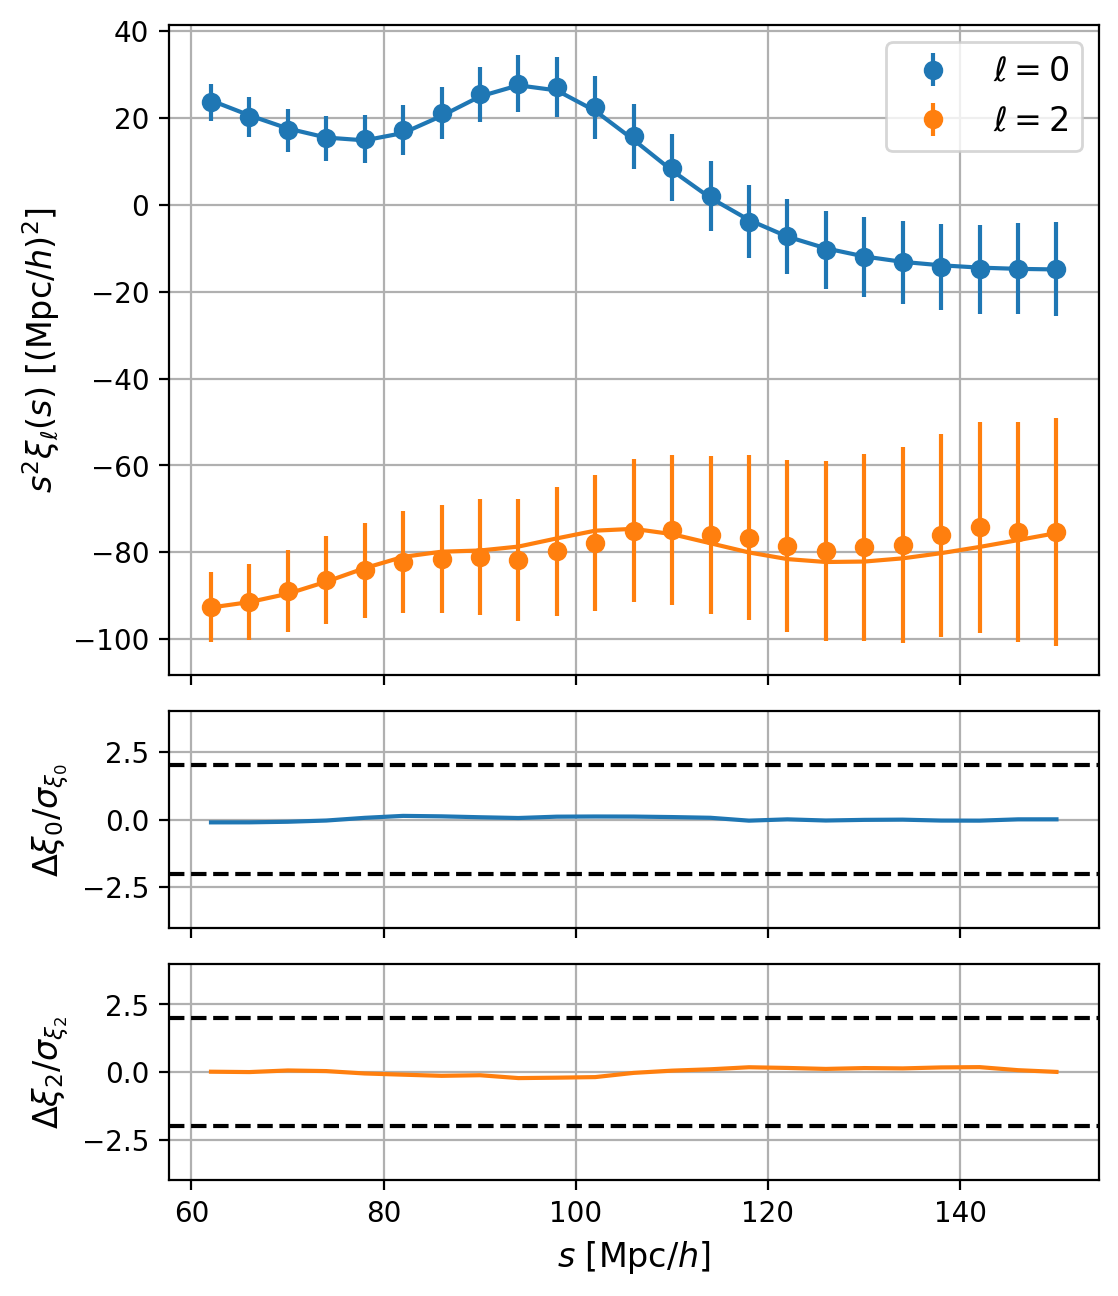

In [76]:
task = 'test_cubic_cosmo'
tracer = 'LRG'
redshift =  0.5
grid_cosmo = '002'
recon  = True

data_args = {"tracer": tracer, "z_eff": redshift, "recon": recon, "grid_cosmo": grid_cosmo}
observable, likelihood = set_bao_likelihood(task, data_args)
profiler = MinuitProfiler(likelihood, seed=42)
profiles = profiler.maximize()
print(profiles.to_stats(tablefmt='pretty'))
print(likelihood(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

In [77]:
# MCMC sampling
nwalkers = 64 
interations = 3001 # save every 300 iterations

chain_fn = './test/test.npy'
sampler = EmceeSampler(likelihood, seed=40, nwalkers=nwalkers, save_fn = chain_fn)
sampler.run(check={'max_eigen_gr': 0.1}, max_iterations = interations) # save every 300 iterations

[001329.00] [0/1] 02-13 08:23  EmceeSampler              INFO     Varied parameters: ['qiso', 'qap', 'b1', 'dbeta', 'sigmas', 'sigmapar', 'sigmaper', 'al2_0', 'al2_1', 'bl0_0', 'bl0_2', 'bl2_0', 'bl2_2'].


[001329.56] [0/1] 02-13 08:23  EmceeSampler              INFO     Successfully vmap input likelihood.
[001330.75] [0/1] 02-13 08:23  EmceeSampler              INFO     Successfully jit input likelihood.
[001332.12] [0/1] 02-13 08:23  TaskManager               INFO     Entering TaskManager with 1 workers.
[001364.37] [0/1] 02-13 08:23  Chain                     INFO     Saving ./test/test.npy.
[001364.38] [0/1] 02-13 08:23  EmceeSampler              INFO     Diagnostics:
[001364.43] [0/1] 02-13 08:23  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.502; not < 0.1.
[001364.48] [0/1] 02-13 08:23  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.215.
[001364.66] [0/1] 02-13 08:23  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.625.
[001364.69] [0/1] 02-13 08:23  Diagnostics               INFO     - max Geweke is 0.305.
[001364.70] [0/1] 02-13 08:23  Diagnostics               INFO     - Geweke p-value is 0.00012.
[00

[Chain(shape=(3001, 64), params=ParameterCollection(['qiso', 'qap', 'b1', 'dbeta', 'sigmas', 'sigmapar', 'sigmaper', 'al2_0', 'al2_1', 'bl0_0', 'bl0_2', 'bl2_0', 'bl2_2', 'logposterior', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al2_-1', 'al2_2', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'loglikelihood', 'logprior']))]

[001493.39] [0/1] 02-13 08:25  Chain                     INFO     Loading ./test/test.npy.


+----------+---------+---------+---------+--------+-----------------+-----------------+
|          | argmax  |  mean   | median  |  std   | quantile:1sigma | interval:1sigma |
+----------+---------+---------+---------+--------+-----------------+-----------------+
|   qiso   |  1.072  |  1.068  |  1.070  | 0.025  |  -0.020/+0.022  |  -0.020/+0.023  |
|   qap    |  1.011  |  1.005  |  1.002  | 0.068  |  -0.065/+0.067  |  -0.070/+0.060  |
|    b1    |  1.51   |  1.49   |  1.49   |  0.18  |   -0.18/+0.18   |   -0.18/+0.17   |
|  dbeta   |  0.74   |  0.97   |  0.95   |  0.17  |   -0.19/+0.21   |  -0.270/+0.094  |
|  sigmas  |   7.0   |   4.2   |   3.8   |  2.9   |    -3.3/+3.6    |    -4.2/+1.6    |
| sigmapar |    9    |    4    |    9    |   11   |    -15/+10.     |     -13/+11     |
| sigmaper |  -4.8   |   0.7   |   0.9   |  5.6   |    -6.2/+5.9    |    -5.8/+6.2    |
|  al2_0   |   80.   |   37    |   36    |   58   |    -59/+60.     |     -65/+53     |
|  al2_1   |   0.7   |   0.5   |

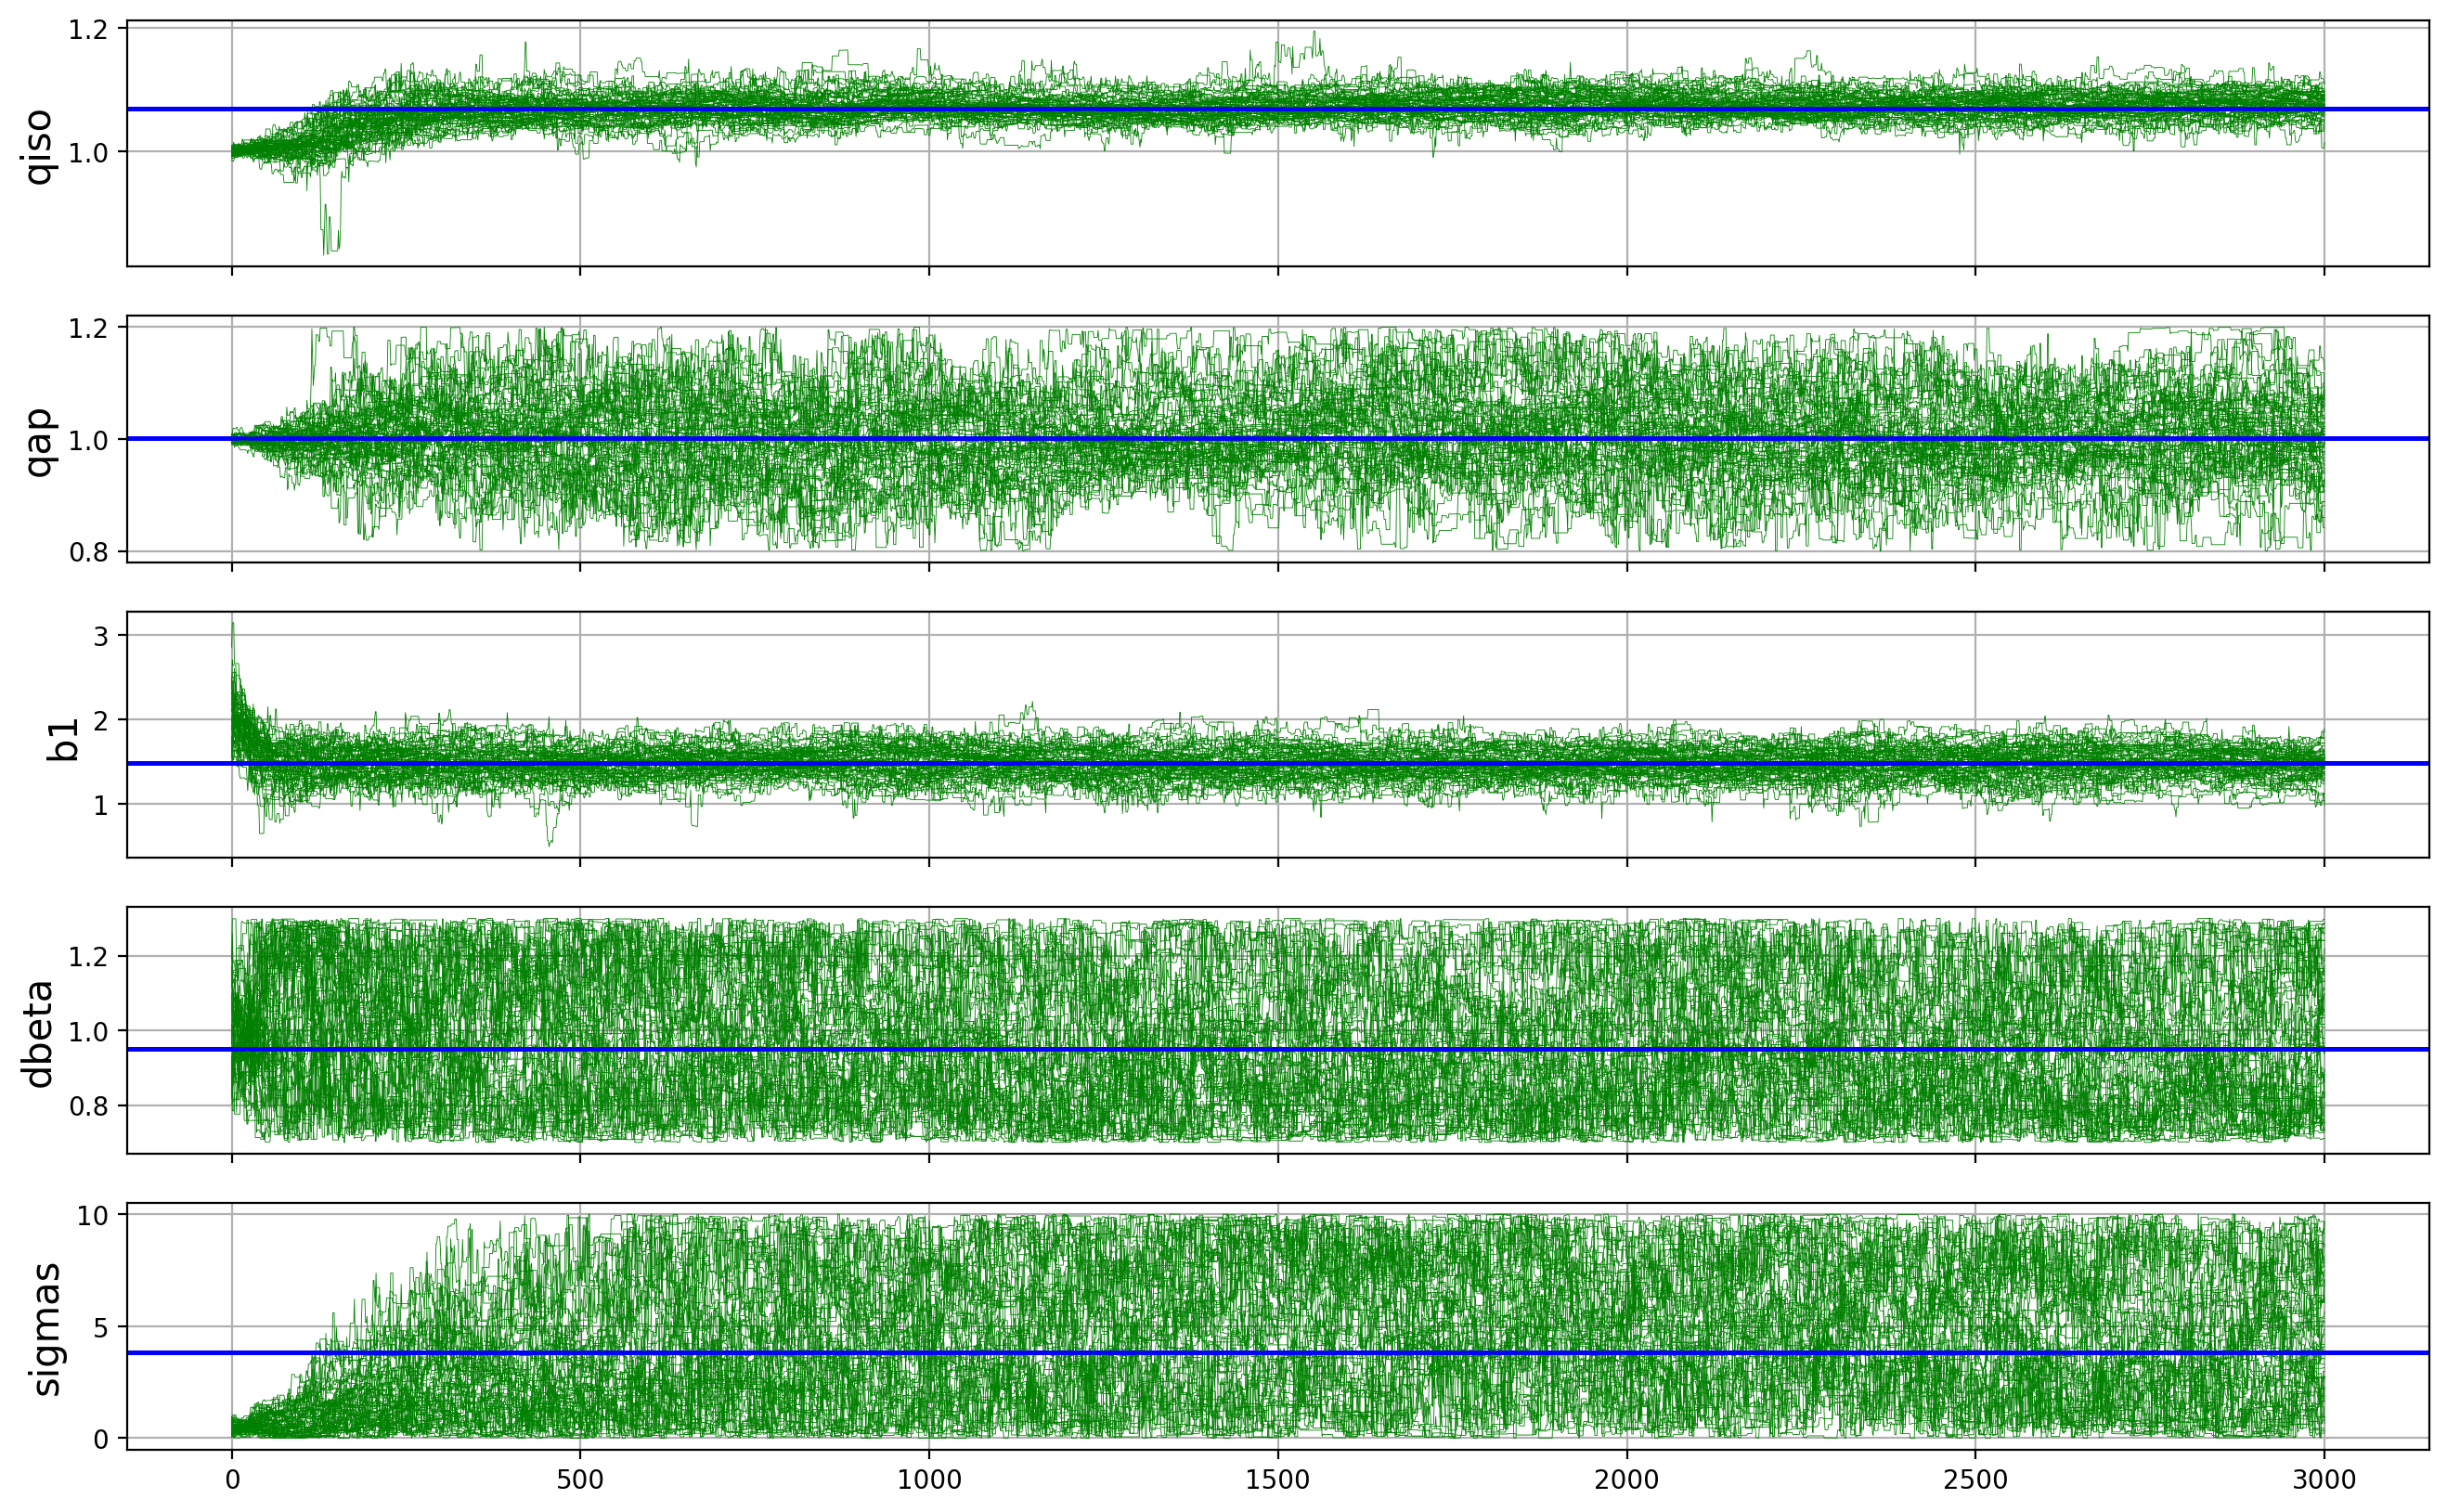

In [78]:
from fit_cubic_tools import plot_mcmc_walkers, plot_mcmc_contour
chain_fn = './test/test.npy'
chain = Chain.load(chain_fn).remove_burnin()[::]
print(chain.to_stats(tablefmt='pretty'))
plot_mcmc_walkers(chain, params= ['qiso', 'qap', 'b1', 'dbeta', 'sigmas'])

[001497.67] [0/1] 02-13 08:25  Chain                     INFO     Loading ./test/test.npy.
Removed no burn in


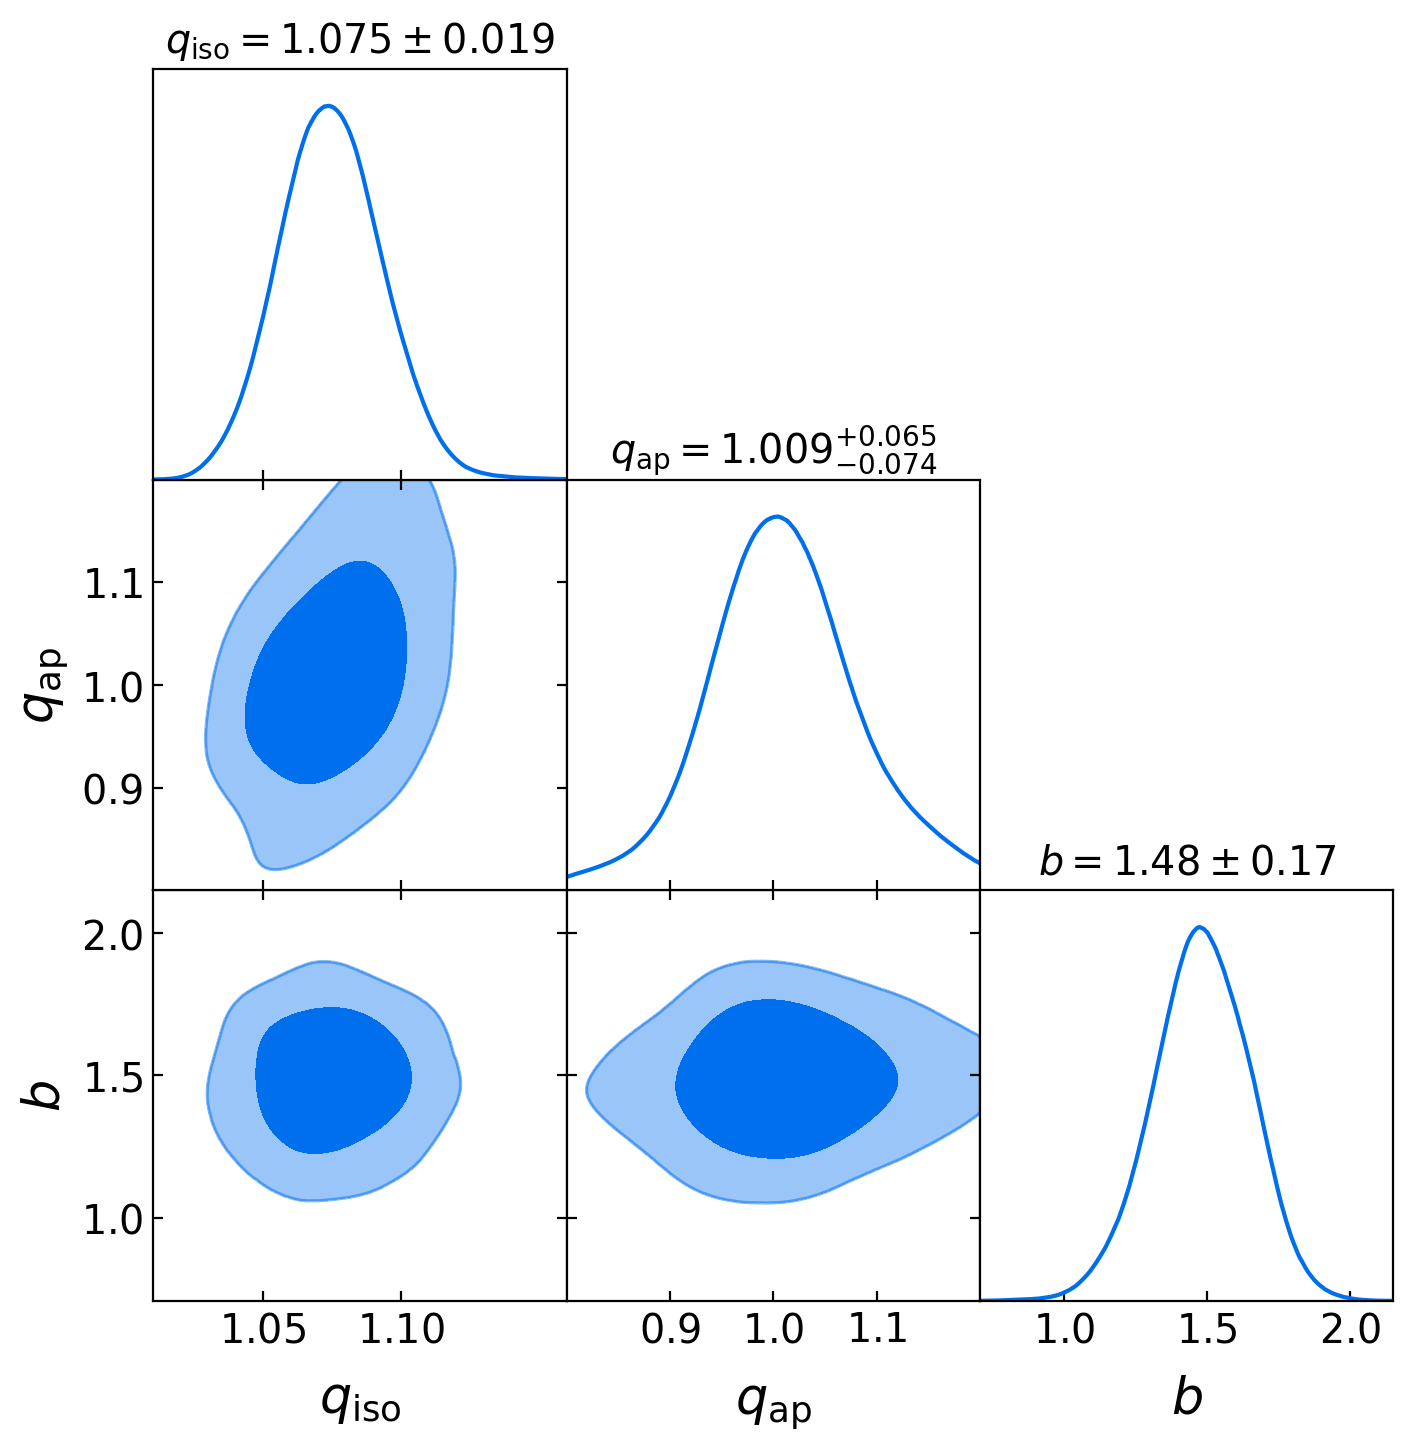

In [79]:
burnin=  0.50
slice_step = 60
chain_fn = './test/test.npy'
chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]
plot_mcmc_contour(chain, params= ['qiso', 'qap', 'b1'])

### Post- processing, comsological parameters constraints

In [73]:
if grid_cosmo == '000':
    cosmo = DESI()
elif grid_cosmo == '002':
    cosmo = AbacusSummit(2)

chain_fn = './test/test.npy'
chain = Chain.load(chain_fn).remove_burnin()[::]
observable = BAOCompressionObservable(data=chain, covariance=chain, z=redshift, quantities=['qiso','qap'], fiducial=cosmo)
likelihood = ObservablesGaussianLikelihood(observables=[observable],)
likelihood()

[000364.34] [0/1] 02-13 08:07  Chain                     INFO     Loading ./test/test.npy.


[000364.49] [0/1] 02-13 08:07  BAOCompressionObservable  INFO     Found quantities ['qiso', 'qap'].


Array(-0.40085555, dtype=float64)

In [ ]:
# from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
# emulator_fn = './test/emulator.npy'
# emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
# emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
# emulator.fit()
# emulator.save(emulator_fn)

In [74]:
chain_cosmo_fn = './test/chain_cosmo.npy'
sampler = EmceeSampler(likelihood, seed=42, nwalkers=nwalkers, save_fn = chain_cosmo_fn)
sampler.run(check={'max_eigen_gr': 0.02})

[000368.21] [0/1] 02-13 08:07  EmceeSampler              INFO     Varied parameters: ['Omega_m'].


[000368.43] [0/1] 02-13 08:07  EmceeSampler              INFO     Could *not* vmap input likelihood. Set logging level to debug (setup_logging("debug")) to get full stack trace.
[000368.46] [0/1] 02-13 08:07  EmceeSampler              INFO     Could *not* jit input likelihood.
[000375.27] [0/1] 02-13 08:07  TaskManager               INFO     Entering TaskManager with 1 workers.
emcee: Exception while calling your likelihood function:
  params: [[0.33120487]
 [0.30862246]
 [0.46752968]
 [0.4381655 ]
 [0.24275413]
 [0.38662457]
 [0.32164274]
 [0.42976416]
 [0.36504742]
 [0.46504131]
 [0.38790727]
 [0.37165874]
 [0.29135296]
 [0.35715844]
 [0.3901641 ]
 [0.32978848]
 [0.33863692]
 [0.24504447]
 [0.27862972]
 [0.36709311]
 [0.37460316]
 [0.38808344]
 [0.33161612]
 [0.39984543]
 [0.32109953]
 [0.2815766 ]
 [0.36962793]
 [0.3636975 ]
 [0.49177133]
 [0.40180449]
 [0.3326131 ]
 [0.45884143]]
  args: []
  kwargs: {}
  exception:
[001258.93] [0/1] 02-13 08:21  Exception                 CRITICAL 

Traceback (most recent call last):
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samplers/base.py", line 61, in wrapper
    toret[mask] = func(self, values)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samplers/base.py", line 151, in logposterior
    results = self._vlikelihood(points.to_dict())
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/samplers/base.py", line 264, in _vlikelihood
    return vlikelihood(*args, **kwargs, mpicomm=self.mpicomm)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/base.py", line 324, in wrapper
    states = calculate(chunk_params, **kw)
  File "/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/base

KeyboardInterrupt: 

In [75]:
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.extractor.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})

AttributeError: 'NoneType' object has no attribute 'remove_burnin'